In [1]:
import pandas as pd
import pickle
from rdkit import Chem
# Core sklearn modules
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Preprocessing and pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline

# Model evaluation
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix
)

# External libraries
from xgboost import XGBClassifier  # xgboost==2.1.4

# Additional imports for NaN handling (from previous code)
from sklearn.calibration import CalibratedClassifierCV
from sklearn.impute import SimpleImputer
import numpy as np
from tqdm import tqdm

# Load models

In [2]:
with open("../models/ml_models_mordred.pkl", "rb") as f:
    models = pickle.load(f)

# Load data for calibration LinearSVC, SGDClassifier, RidgeClassifier

In [3]:
with open("../data/antidiabetic/antidiabetic_mordred_descriptors.pkl", "rb") as f:
    antidiabetic_mordred_descriptors = pickle.load(f)

In [4]:
with open("../data/non_antidiabetic/non_antidiabetic_mordred_descriptors.pkl", "rb") as f:
    non_antidiabetic_mordred_descriptors = pickle.load(f)

In [5]:
antidiabetic_mordred_descriptors['y'] = 1
non_antidiabetic_mordred_descriptors['y'] = -1

df = pd.concat([antidiabetic_mordred_descriptors, non_antidiabetic_mordred_descriptors], ignore_index=True) # data_fit_MODELs_mordred.pkl

In [6]:
X = df.drop(columns="y")
y = df["y"]

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Predict antidiabetic effect

In [8]:
with open('../data/antidiabetic/GEN_valid_smiles.pkl', 'rb') as f:
    valid_smiles = pickle.load(f)

In [9]:
mols = []
for SMILES in valid_smiles:
        mol = Chem.MolFromSmiles(SMILES)
        mols.append(mol)
molSMILES = dict(zip(valid_smiles, mols))

In [10]:
# valid_smiles = [
#     "N(C(=O)Cc1cc(c(OCC)cc1)C(O)=O)CC(C)C",
#     "C12(CC3(CC(CC(C3)C2)C1)O)[C@H](N)C(N1[C@@H](C[C@@H]2C[C@@H]21)C#N)=O",
#     "c1c(OCC)c(ccc1CC(=O)N[C@H](c1c(cccc1)N1CCCCC1)CC(C)C)C(O)=O",
#     "C1CN([C@@H]2C[C@H]21)C(=O)[C@@H](N)C12CC3CC(CC(O)(C3)C1)C2",
#     "C1C2(CC3CC(C2)CC1(C3)O)[C@@H](C(N1[C@H](C#N)C[C@H]2[C@@H]1C2)=O)N",
#     "C1C2(CC3CC(CC1(C3)C2)NCC(=O)N1CCC[C@H]1C#N)O",
#     "F[C@H](CC(N1CCn2c(nnc2C(F)(F)F)C1)=O)N",
#     "C12CC3(CC(O)(CC(C3)C1)C2)[C@H](N)C(=O)N1[C@H](C#N)C[C@@H]2C[C@H]12",
#     "c12c(nnc(C(F)(F)F)c2CCN(C1)C(C[C@@H](Cc1c(cc(F)c(F)c1)F)N)=O)F",
#     "N1(C(C[C@@H](Cc2cc(F)c(cc2F)F)N)=O)Cc2nnc(C(F)(F)F)n2CC1"
# ]
# mols = []
# for SMILES in valid_smiles:
#     mol = Chem.MolFromSmiles(SMILES)
#     if mol is not None:
#         mols.append(mol)
# molSMILES = dict(zip(valid_smiles, mols))

In [11]:
from mordred import Calculator, descriptors
from tqdm import tqdm
import pandas as pd

# Initialize calculator with built-in descriptors
calc = Calculator(descriptors, ignore_3D=False)

# Get descriptor names
descriptor_names = [str(d) for d in calc.descriptors]

# Dictionary to hold results
d = {}

# molSMILES is a dict: {SMILES: mol}
for SMILES, mol in tqdm(molSMILES.items()):
    try:
        result = calc(mol)
        d[SMILES] = result.asdict()  # Convert result to dictionary
    except Exception as e:
        print(f"Failed on molecule {SMILES}: {e}")
        # d[SMILES] = dict(zip(descriptor_names, [None] * len(descriptor_names)))

100%|█████████████████████████████████████████| 289/289 [00:25<00:00, 11.27it/s]


In [12]:
# Преобразуем словарь результатов в DataFrame
df_descriptors = pd.DataFrame.from_dict(d, orient='index')

# Добавляем SMILES как отдельный столбец
df_descriptors.reset_index(inplace=True)
df_descriptors.rename(columns={'index': 'SMILES'}, inplace=True)

# Устанавливаем SMILES как индекс
df_descriptors.set_index('SMILES', inplace=True)

In [13]:
descriptors = df_descriptors.applymap(lambda x: x if isinstance(x, (int, float, np.number)) else -1)

/tmp/ipykernel_2851/2873753369.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  descriptors = df_descriptors.applymap(lambda x: x if isinstance(x, (int, float, np.number)) else -1)


In [14]:
from sklearn.calibration import CalibratedClassifierCV
import pandas as pd

# Словарь для вероятностей
predictions = {}

# Предсказания вероятностей от всех моделей
for model_name, model in models.items():
    if isinstance(model, (LinearSVC, SGDClassifier, RidgeClassifier)):
        calibrated = CalibratedClassifierCV(model, cv="prefit")
        calibrated.fit(X_test, y_test)
        proba = calibrated.predict_proba(descriptors)
    else:
        proba = model.predict_proba(descriptors)
    
    predictions[model_name] = proba[:, 1]  # Предполагаем, что бинарная классификация

# Преобразуем в DataFrame
df_predictions = pd.DataFrame(predictions, index=descriptors.index)

# Добавим SMILES как отдельный столбец (если он в индексе)
df_predictions.reset_index(inplace=True)

/opt/conda/lib/python3.12/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(
/opt/conda/lib/python3.12/site-packages/sklearn/calibration.py:333: UserWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


In [15]:
from IPython.display import display, HTML
# Assuming your DataFrame is named `df_proba`
columns_to_sort_by = ['Random Forest', 'Gradient Boosting']

# Add a helper column with the max of just those two columns
df_predictions['max_selected'] = df_predictions[columns_to_sort_by].max(axis=1)

# Sort the full DataFrame by that max value
df_sorted = df_predictions.sort_values(by='max_selected', ascending=False)

# Optionally, drop the helper column afterward
df_sorted = df_sorted.drop(columns='max_selected')
display(HTML(df_sorted[['SMILES', 'Random Forest', 'Gradient Boosting']].to_html()))

,SMILES,Random Forest,Gradient Boosting
160,CC(CCOc1ccc(CC2SC(=O)NC2=O)cc1)c1ccccn1,0.46,0.961684
38,Cc1ccc(N(C)CCOc2ccc(CC3SC(=O)NC3=O)cc2)nc1,0.34,0.956793
162,CN(CCOc1ccc(CC2SC(=O)NC2=O)cc1)C1=CC=N1,0.31,0.950782
282,CN(COCCc1ccc(CC2SC(=O)NC2=O)cc1)c1ccccn1,0.45,0.946920
53,CN(CCCOc1ccc(CC2SC(=O)NC2=O)cc1)c1ccccn1,0.27,0.936351
266,CN(CCOc1ccc(CC2SC(=O)NC2=O)cc1)c1cccnn1,0.34,0.935334
11,CN(CCOc1ccc(CC2SC(=O)NC2=O)cc1)c1ccccc1,0.39,0.934021
207,CN(CCOc1ccc(CC2SC(=O)NC2=O)cc1)C1=NC=C1,0.30,0.932743
2,CN(CCOc1ccc(CC2SC(=O)NC2=O)cc1)c1ccccn1,0.60,0.931659
188,CN(CCCOc1ccc(CC2SC(=O)NC2=O)cc1)c1ccncn1,0.28,0.931171


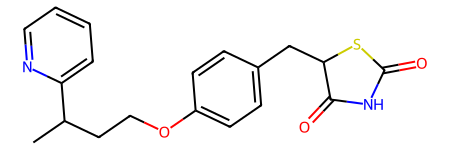

In [16]:
mol = Chem.MolFromSmiles('CC(CCOc1ccc(CC2SC(=O)NC2=O)cc1)c1ccccn1') # Or use mol file 3D
display(mol)